# Reward-based POIS analysis
In this notebook we are going to show the results of the reward-based importance weighting for the POIS algorithm. As in PDIS notebook, we start by loading all our runs and by defining a base run filter.

In [1]:
import pandas as pd
import numpy as np
import glob, sys, json, re
import matplotlib.pyplot as plt
import scipy.stats as sts
from sacred_notebook_utils import load_runs, filter_runs, plot_mean_ci, plot_all

In [2]:
runs = load_runs('../sacred_runs/')
print("Loaded runs:", len(runs.keys()))

Loaded runs: 419


In [3]:
base_query = {
    'run.status': 'COMPLETED',
    'config.center': False,
    'config.gamma': 0.99,
    'config.clipping': False,
    'config.njobs': 1,
    'config.natural': False,
    'config.policy': 'linear',
    'config.iw_norm': 'none'
}

## CartPole as a test
Now we are going to see if the reward-based POIS has a comparative performance w.r.t. vanilla POIS, given also that in the CartPole environment the rewards are very broadly distributed, since the reward is simply the length of the episode times 10. It ranges from 0 to 5000. This means that, without any reward clustering, the reward-based estimator should work the same as the vanilla estimator.

----------------------------------------
Method: is  - Delta: 0.4
Experiments: 5
Seeds: 109, 570, 10, 160, 904
----------------------------------------
Method: rbis  - Delta: 0.2
Experiments: 5
Seeds: 570, 160, 904, 109, 10
----------------------------------------
Method: rbis  - Delta: 0.4
Experiments: 5
Seeds: 160, 570, 109, 10, 904
----------------------------------------
Method: rbis  - Delta: 0.6
Experiments: 5
Seeds: 570, 10, 904, 109, 160
----------------------------------------
Method: rbis  - Delta: 0.9
Experiments: 5
Seeds: 160, 570, 10, 109, 904


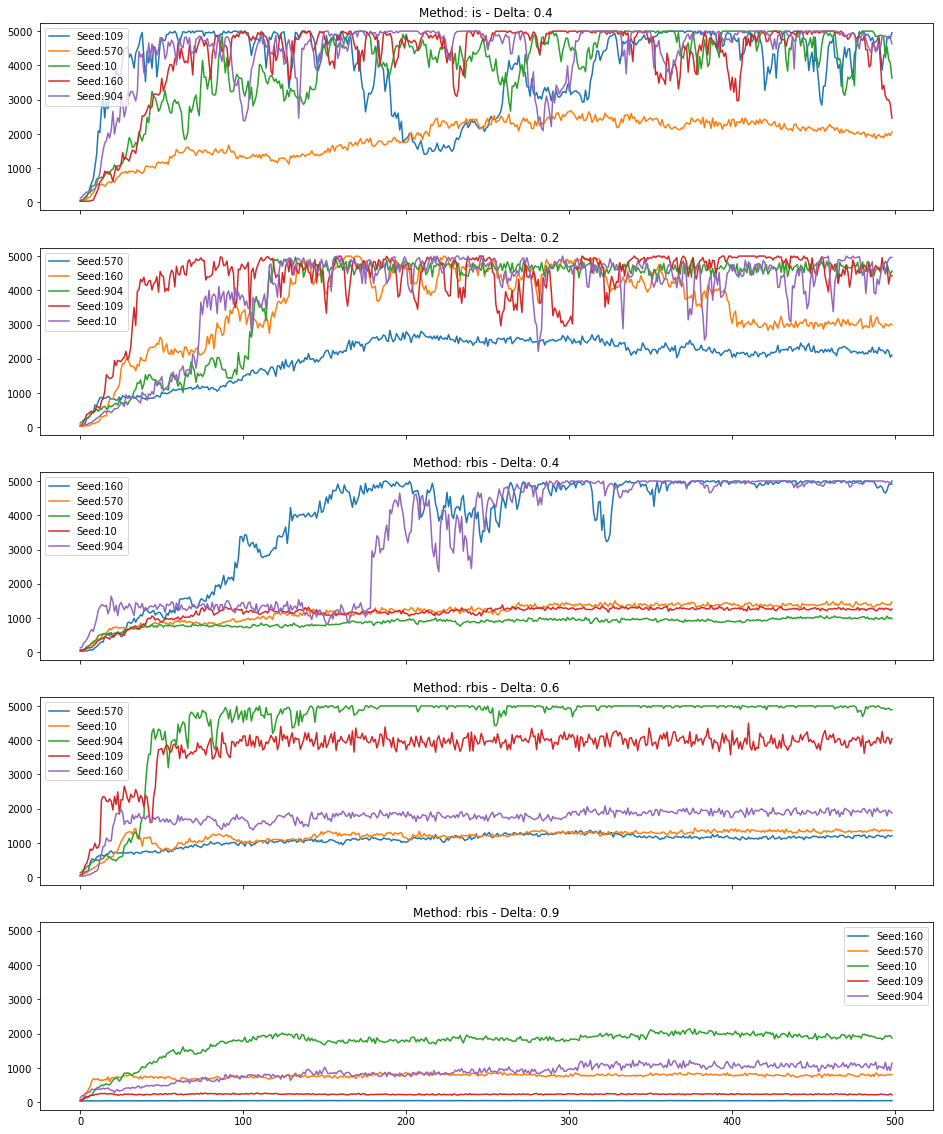

In [4]:
fig, axis = plt.subplots(nrows=5, ncols=1, figsize=(16,20), sharex=True, sharey=True)
for i, (method, delta) in enumerate([('is', 0.4),
                                              ('rbis', 0.2),
                                              ('rbis', 0.4),
                                              ('rbis', 0.6),
                                              ('rbis', 0.9)
                                             ]):
    query = {
        'config.entropy': 'none',
        'config.env': 'rllab.cartpole',
        'config.iw_method': method,
        'config.delta': delta,
        'config.bound': 'max-d2',
        'config.num_episodes': 100,
        'config.reward_clustering': 'none'
    }
    filtered_runs = filter_runs({**base_query, **query}, runs, avoid_missing=False)
    print('----------------------------------------')
    print("Method:", method, " - Delta:", delta)
    print("Experiments:", len(filtered_runs.keys()))
    print("Seeds:", ", ".join(map(str, [filtered_runs[key]['config']['seed'] for key in filtered_runs.keys()])))
    plot_all(filtered_runs, 'EpRewMean', axis[i])
    axis[i].set_title("Method: " + method + " - Delta: " + str(delta))
plt.show();

As we can notice, a delta of 0.2 makes the RBIS estimator comparable to the vanilla one, while being quite sensible to the choice of delta.

## Reward clustering
Now we want to understand the influence of the reward clustering w.r.t. the performances of the algorithm. We start with a "manual" reward clustering (again on rllab.cartpole) from 0 to 5000 with 1000 intervals of 5

----------------------------------------
Method: rbis  - Delta: 0.1
Experiments: 5
Seeds: 10, 109, 160, 904, 570
----------------------------------------
Method: rbis  - Delta: 0.2
Experiments: 5
Seeds: 109, 570, 904, 10, 160
----------------------------------------
Method: rbis  - Delta: 0.4
Experiments: 5
Seeds: 570, 904, 160, 109, 10


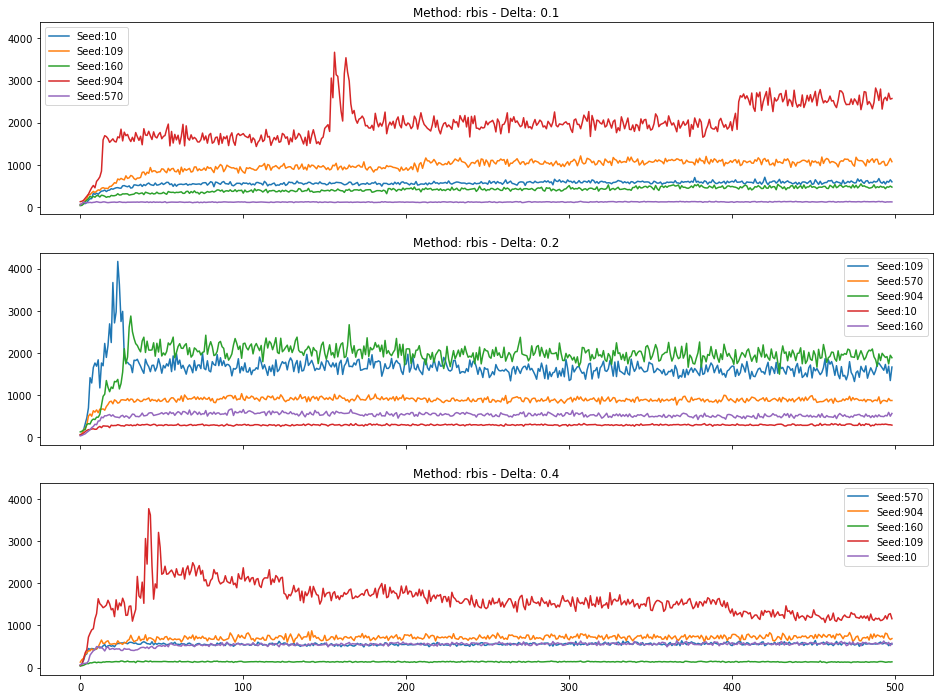

In [5]:
fig, axis = plt.subplots(nrows=3, ncols=1, figsize=(16,12), sharex=True, sharey=True)
for i, (method, delta) in enumerate([('rbis', 0.1),
                                    ('rbis', 0.2),
                                    ('rbis', 0.4)
                                             ]):
    query = {
        'config.entropy': 'none',
        'config.env': 'rllab.cartpole',
        'config.iw_method': method,
        'config.delta': delta,
        'config.bound': 'max-d2',
        'config.num_episodes': 100,
        'config.reward_clustering': 'manual:1000:0:5000'
    }
    filtered_runs = filter_runs({**base_query, **query}, runs)
    print('----------------------------------------')
    print("Method:", method, " - Delta:", delta)
    print("Experiments:", len(filtered_runs.keys()))
    print("Seeds:", ", ".join(map(str, [filtered_runs[key]['config']['seed'] for key in filtered_runs.keys()])))
    plot_all(filtered_runs, 'EpRewMean', axis[i])
    axis[i].set_title("Method: " + method + " - Delta: " + str(delta))
plt.show();

----------------------------------------
Method: rbis  - Delta: 0.01
Experiments: 5
Seeds: 10, 570, 904, 109, 160
----------------------------------------
Method: rbis  - Delta: 0.1
Experiments: 5
Seeds: 109, 904, 160, 570, 10
----------------------------------------
Method: rbis  - Delta: 0.2
Experiments: 5
Seeds: 160, 109, 10, 904, 570


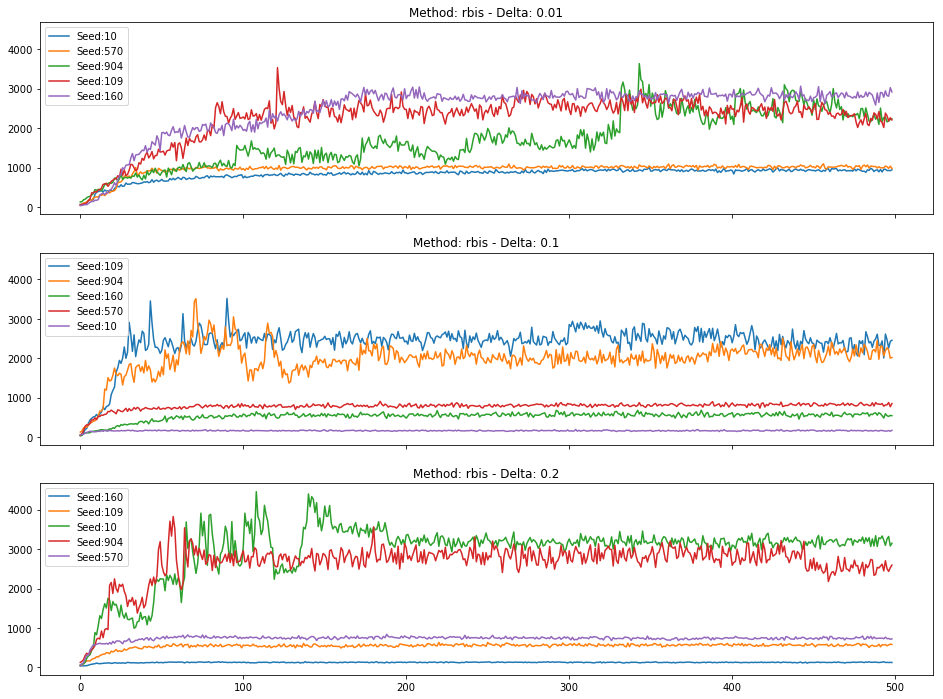

In [6]:
fig, axis = plt.subplots(nrows=3, ncols=1, figsize=(16,12), sharex=True, sharey=True)
for i, (method, delta) in enumerate([('rbis', 0.01),
                                    ('rbis', 0.1),
                                    ('rbis', 0.2)
                                             ]):
    query = {
        'config.entropy': 'none',
        'config.env': 'rllab.cartpole',
        'config.iw_method': method,
        'config.delta': delta,
        'config.bound': 'max-d2',
        'config.num_episodes': 100,
        'config.reward_clustering': 'manual:50000:0:5000'
    }
    filtered_runs = filter_runs({**base_query, **query}, runs)
    print('----------------------------------------')
    print("Method:", method, " - Delta:", delta)
    print("Experiments:", len(filtered_runs.keys()))
    print("Seeds:", ", ".join(map(str, [filtered_runs[key]['config']['seed'] for key in filtered_runs.keys()])))
    plot_all(filtered_runs, 'EpRewMean', axis[i])
    axis[i].set_title("Method: " + method + " - Delta: " + str(delta))
plt.show();

## Second version of the estimator
Since the first version of the estimator
$$\hat{J}= \frac{1}{|R|}\sum_{c \in R}{\omega(c) r(c)}$$ 
where R is the set of reward clusters, omega is the importance weight and r(c) is the reward of the cluster
has clearly some problems, we modified it to:
$$\hat{J}= \frac{1}{|N|}\sum_{c \in R}{\omega(c) r(c) n(c)}$$ 
where N is the number of trajectories and n(c) is the number of trajectories in the cluster.
So, we now plot some results to understand if the previous estimator was not correct.

Again, we first test the method without reward clustering to understand if the algorithm is working in a basic case.

----------------------------------------
Method: is  - Delta: 0.4
Experiments: 5
Seeds: 109, 570, 10, 160, 904
----------------------------------------
Method: rbis  - Delta: 0.2
Experiments: 5
Seeds: 160, 109, 570, 904, 10
----------------------------------------
Method: rbis  - Delta: 0.4
Experiments: 5
Seeds: 570, 904, 109, 10, 160
----------------------------------------
Method: rbis  - Delta: 0.6
Experiments: 5
Seeds: 904, 160, 109, 570, 10
----------------------------------------
Method: rbis  - Delta: 0.8
Experiments: 5
Seeds: 904, 10, 570, 109, 160


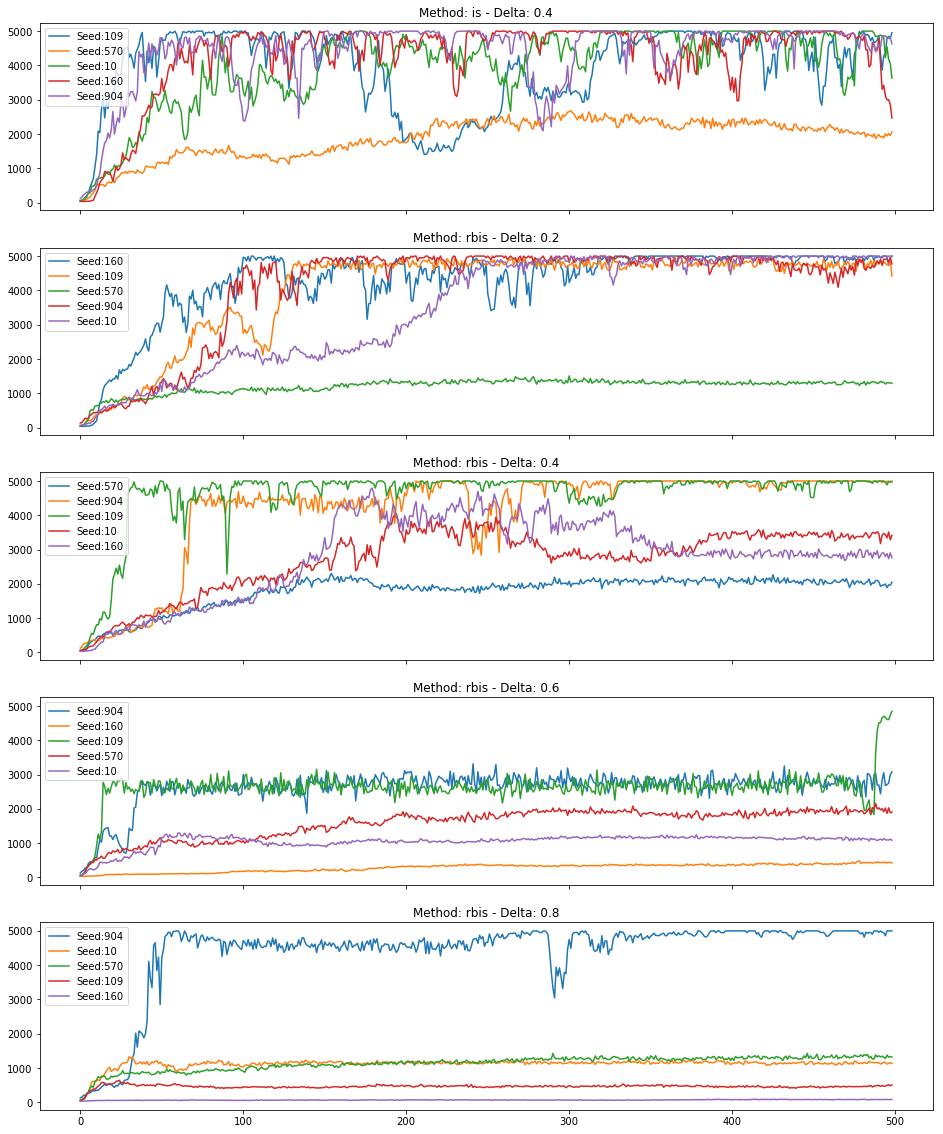

In [6]:
# We used iw_norm to set version of the estimator. So we first remove it from the base query
base_query.pop('iw_norm', None)

fig, axis = plt.subplots(nrows=5, ncols=1, figsize=(16,20), sharex=True, sharey=True)
for i, (method, delta, iw_norm) in enumerate([('is', 0.4, 'none'),
                                              ('rbis', 0.2, 'clustrew'),
                                              ('rbis', 0.4, 'clustrew'),
                                              ('rbis', 0.6, 'clustrew'),
                                              ('rbis', 0.8, 'clustrew')
                                             ]):
    query = {
        'config.entropy': 'none',
        'config.env': 'rllab.cartpole',
        'config.iw_method': method,
        'config.delta': delta,
        'config.bound': 'max-d2',
        'config.num_episodes': 100,
        'config.reward_clustering': 'none',
        'config.iw_norm': iw_norm
    }
    filtered_runs = filter_runs({**base_query, **query}, runs, avoid_missing=False)
    print('----------------------------------------')
    print("Method:", method, " - Delta:", delta)
    print("Experiments:", len(filtered_runs.keys()))
    print("Seeds:", ", ".join(map(str, [filtered_runs[key]['config']['seed'] for key in filtered_runs.keys()])))
    plot_all(filtered_runs, 'EpRewMean', axis[i])
    axis[i].set_title("Method: " + method + " - Delta: " + str(delta))
plt.show();

# TODO
- Different deltas to make cartpole work
- Cartpole with increasing reward_clustering N